In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from backtest_functions import *

### preprocess

In [2]:
df = pd.read_parquet('../data_processing/v3_grouped_by_day_cusip.gzip.parquet')

df.rename({'month':'year_month'}, axis=1, inplace=True)
df['year'] = df['year_month'].dt.year
df['month'] = df['year_month'].dt.month

print(df.shape)
print(df.columns)

(872206, 43)
Index(['year_month', 'cusip', 'ratingOverall', 'ratingCareerOpportunities',
       'ratingCompensationAndBenefits', 'ratingCultureAndValues',
       'ratingSeniorLeadership', 'ratingWorkLifeBalance',
       'ratingDiversityAndInclusion', 'ratingBusinessOutlook', 'ratingCeo',
       'ratingRecommendToFriend', 'summary_length', 'pros_length',
       'cons_length', 'advice_length', 'summary_token_count',
       'pros_token_count', 'cons_token_count', 'advice_token_count',
       'summary_sentiment', 'pros_sentiment', 'cons_sentiment',
       'advice_sentiment', 'mkvalt', 'summary_token', 'pros_token',
       'cons_token', 'advice_token', 'innovative_llama', 'integrity_llama',
       'quality_llama', 'respect_llama', 'teamwork_llama', 'review_count',
       'vol_forward_1m', 'return_forward_1m', 'gsector', 'ggroup', 'gind',
       'gsubind', 'year', 'month'],
      dtype='object')


In [3]:
df = df.drop(columns=['summary_token', 'pros_token', 'cons_token', 'advice_token'])

<Axes: xlabel='year_month'>

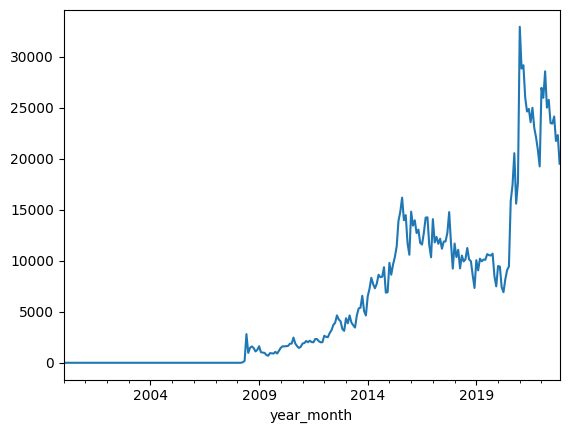

In [4]:
df.groupby('year_month')['review_count'].sum().plot()

In [5]:
df = df[df['year_month'] >= "2014-01"]

In [6]:
cols = ['ratingOverall', 'ratingCareerOpportunities', 'ratingCompensationAndBenefits', 
        'ratingCultureAndValues', 'ratingSeniorLeadership', 'ratingWorkLifeBalance', 
        'ratingDiversityAndInclusion', 'ratingBusinessOutlook', 'ratingCeo', 
        'ratingRecommendToFriend', 'summary_length', 'pros_length', 'cons_length', 
        'advice_length', 'summary_token_count', 'pros_token_count', 'cons_token_count', 
        'advice_token_count', 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 
        'advice_sentiment', 'innovative_llama', 'integrity_llama', 'quality_llama', 
        'respect_llama', 'teamwork_llama']

for col in cols:
  df[col] = np.where(df.review_count >= 15, df[col], np.nan)

In [7]:
# df.drop(columns='ratingDiversityAndInclusion', inplace=True)

In [8]:
df['gsector'] = df['gsector'].astype('float')
df['ggroup'] = df['ggroup'].astype('float')
df['gind'] = df['gind'].astype('float')
df['gsubind'] = df['gsubind'].astype('float')

In [9]:
# to-do: Modification: token count (when sentiment >0.75 or a specify value)
# i.e. return token count if sentiment >0.75 else 0

# df['summary_token_count'] = df['summary_token_count'] * 
# df['pros_token_count'] = df['pros_token_count'] * 
# df['cons_token_count'] = df['cons_token_count'] * 
# df['cons_token_count'] = df['advice_token_count'] * 

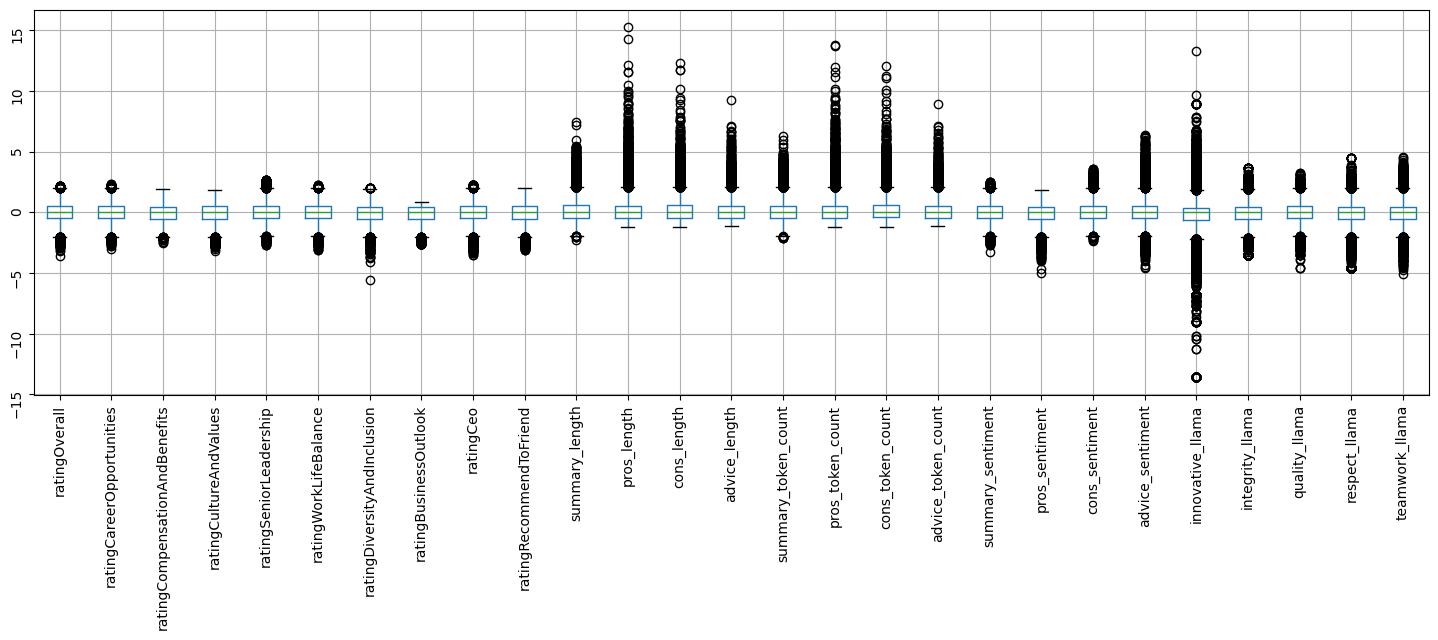

In [10]:
cols_features = ['ratingOverall', 'ratingCareerOpportunities',
                 'ratingCompensationAndBenefits', 'ratingCultureAndValues',
                 'ratingSeniorLeadership', 'ratingWorkLifeBalance', 'ratingDiversityAndInclusion',
                 'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
                 'summary_length', 'pros_length', 'cons_length', 'advice_length',
                 'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count',
                 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
                 'innovative_llama', 'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

scaler = RobustScaler()
df2 = df.copy()
df2[cols_features] = scaler.fit_transform(df2[cols_features])

df2[cols_features].boxplot(figsize = (18,5))
plt.yticks(rotation=90)
plt.xticks(rotation=90)
plt.show()

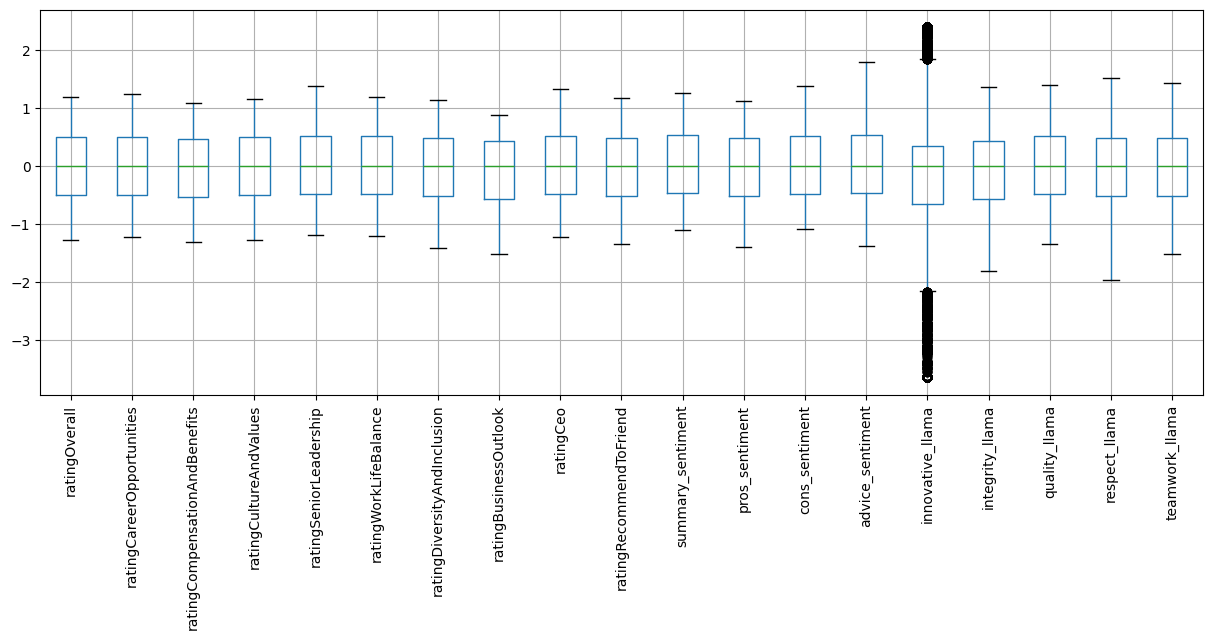

In [11]:
cols_to_scale = ['ratingOverall', 'ratingCareerOpportunities',
                 'ratingCompensationAndBenefits', 'ratingCultureAndValues',
                 'ratingSeniorLeadership', 'ratingWorkLifeBalance', 'ratingDiversityAndInclusion',
                 'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
                 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
                 'innovative_llama', 'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

lower_bound = df[cols_features].quantile(0.05)
upper_bound = df[cols_features].quantile(0.95)
df[cols_to_scale] = df[cols_to_scale].clip(lower=lower_bound, upper=upper_bound, axis=1)

scaler = RobustScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

df[cols_to_scale].boxplot(figsize = (15,5))
plt.xticks(rotation=90)
plt.show()

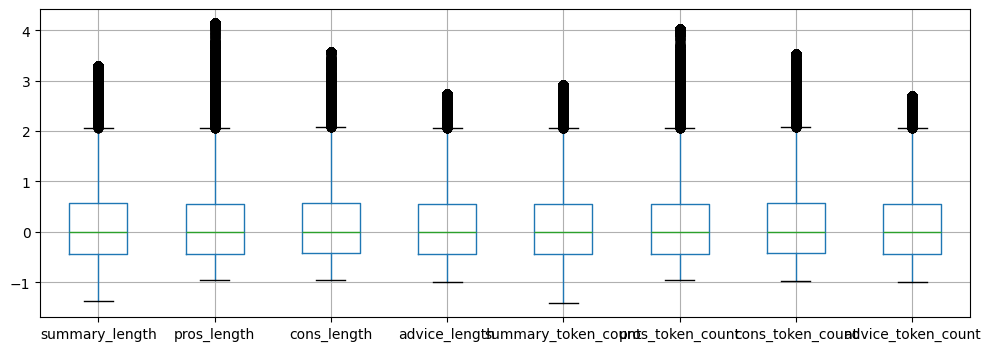

In [12]:
cols_to_scale = ['summary_length', 'pros_length', 'cons_length', 'advice_length', 'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count']
scaler = RobustScaler()

lower_bound = df[cols_to_scale].quantile(0.01)
upper_bound = df[cols_to_scale].quantile(0.99)
df[cols_to_scale] = df[cols_to_scale].clip(lower=lower_bound, upper=upper_bound, axis=1)

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

df[cols_to_scale].boxplot(figsize = (12,4))
plt.xticks(rotation=0)
plt.show()

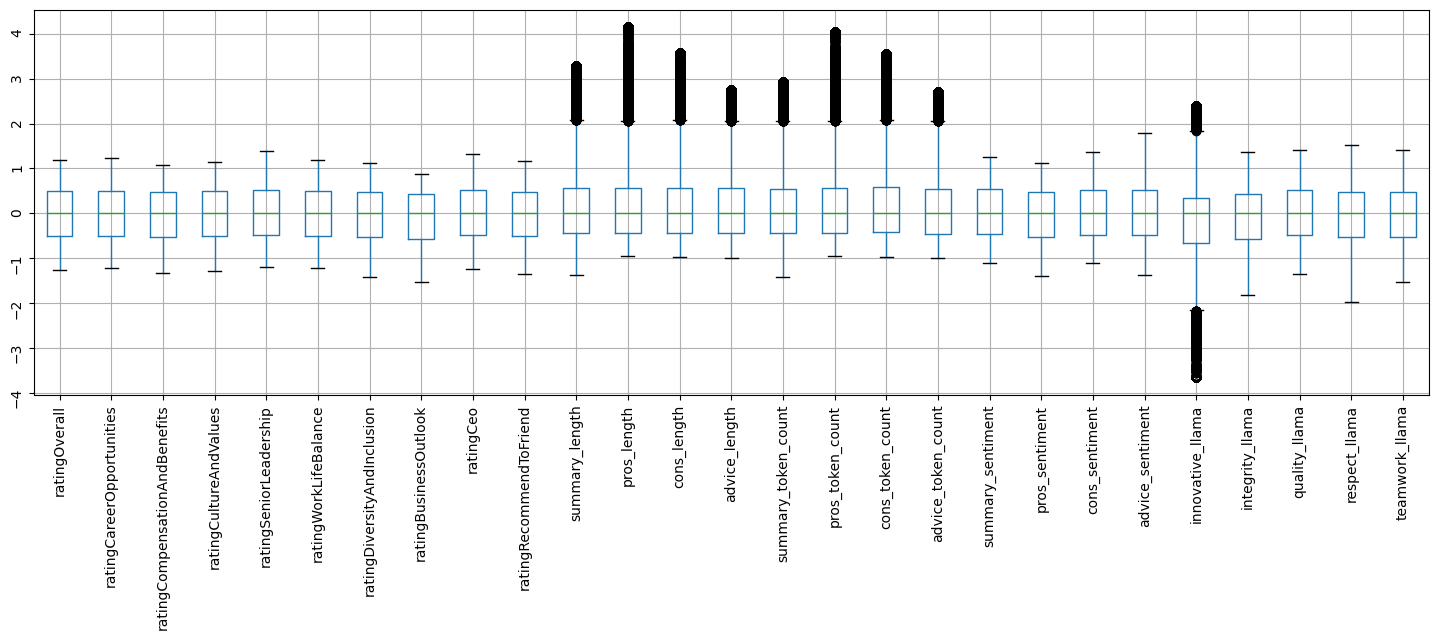

In [13]:
all_features = ['ratingOverall', 'ratingCareerOpportunities',
                 'ratingCompensationAndBenefits', 'ratingCultureAndValues',
                 'ratingSeniorLeadership', 'ratingWorkLifeBalance', 'ratingDiversityAndInclusion',
                 'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
                 'summary_length', 'pros_length', 'cons_length', 'advice_length',
                 'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count',
                 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
                 'innovative_llama', 'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

df[all_features].boxplot(figsize = (18,5))
plt.yticks(rotation=90)
plt.xticks(rotation=90)
plt.show()

In [14]:
df.drop(columns='innovative_llama', inplace=True)

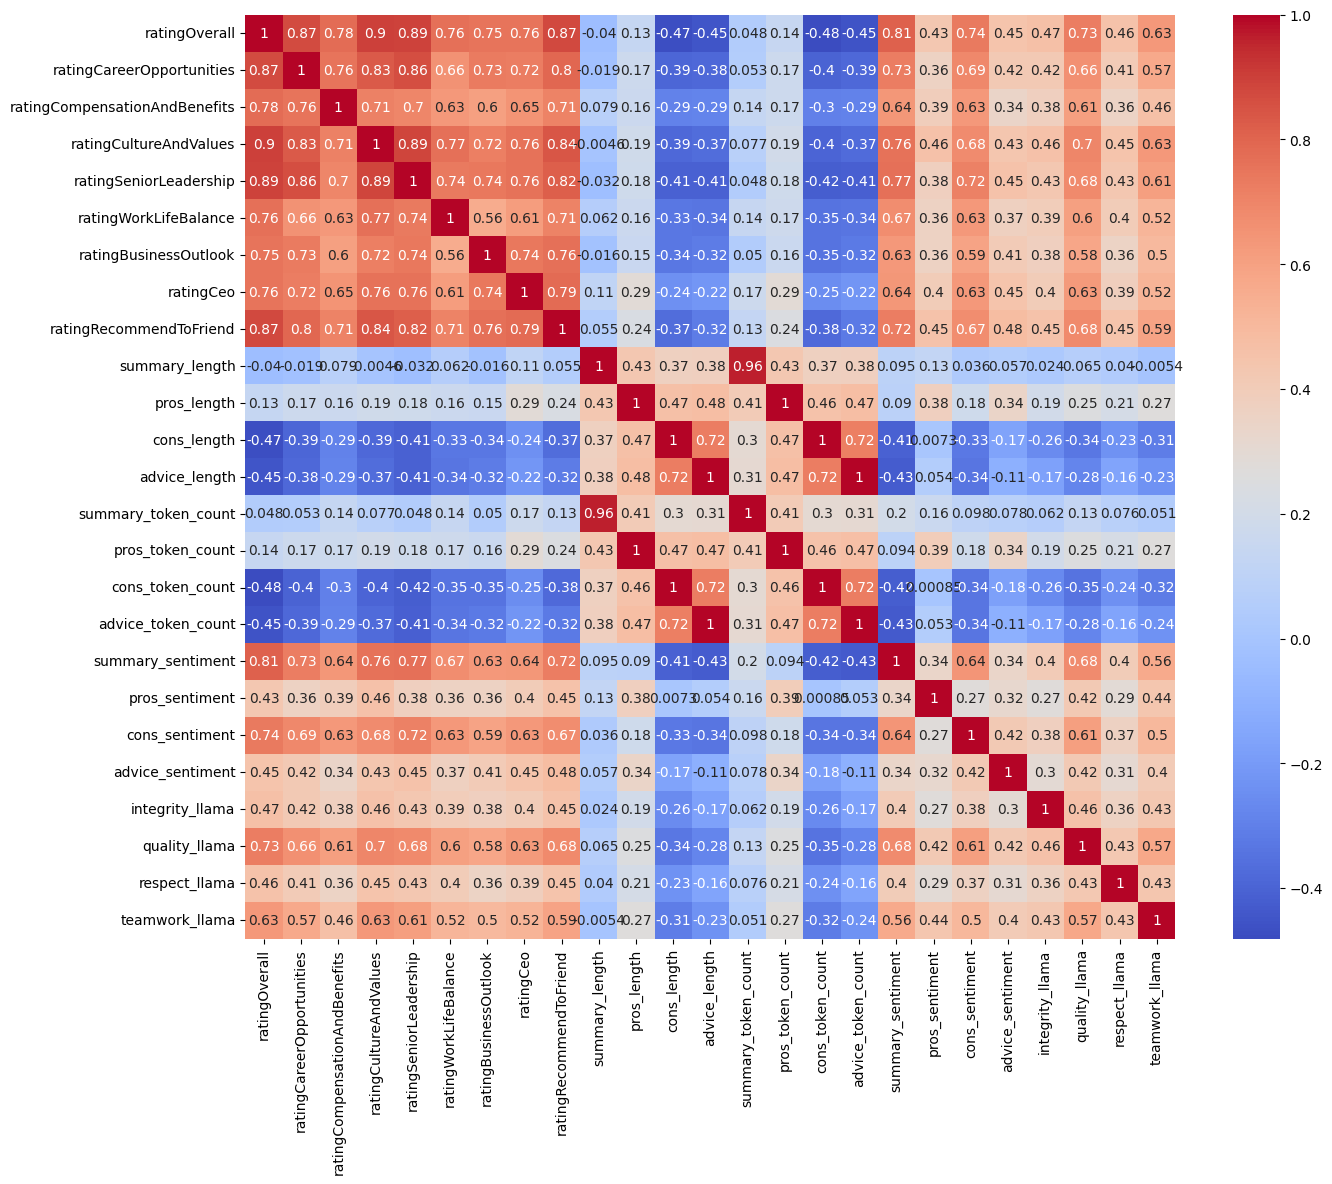

In [15]:
cols = ['ratingOverall', 'ratingCareerOpportunities',
        'ratingCompensationAndBenefits', 'ratingCultureAndValues',
        'ratingSeniorLeadership', 'ratingWorkLifeBalance',
        'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
        'summary_length', 'pros_length', 'cons_length', 'advice_length',
        'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count',
        'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
        'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

corr_matrix = df[cols].corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [16]:
# df['token_rule'] = np.where(
#   df['pros_token_count'] > df['cons_token_count'], 
#   df['pros_token_count'], 
#   -df['cons_token_count']
# )

In [17]:
df.drop(columns=['summary_length', 'pros_length', 'cons_length', 'advice_length'], inplace=True)

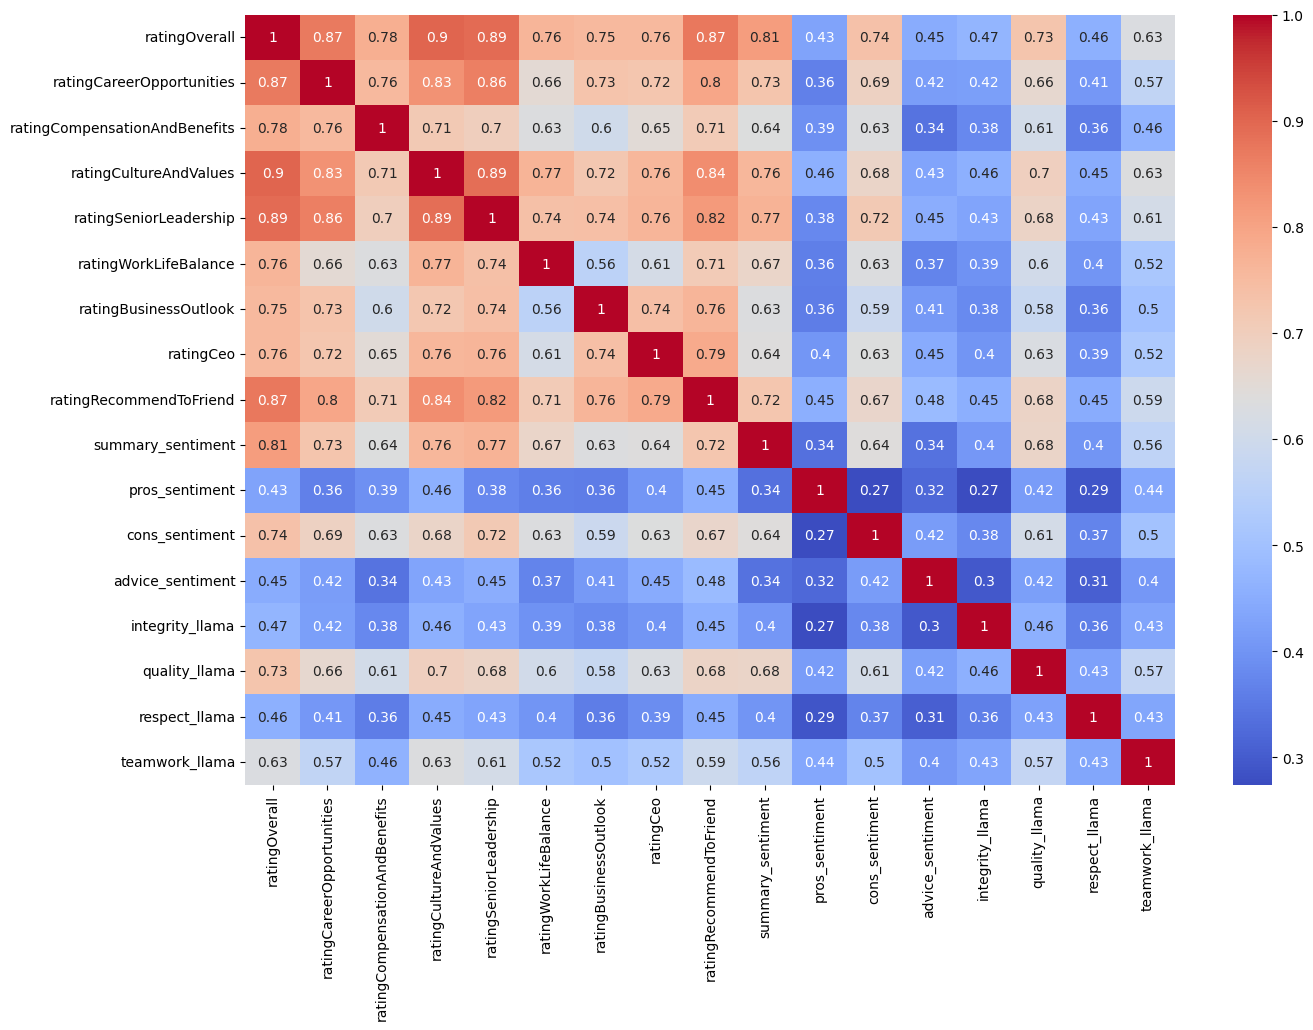

In [18]:
cols_features = ['ratingOverall', 'ratingCareerOpportunities',
                 'ratingCompensationAndBenefits', 'ratingCultureAndValues',
                 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
                 'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
                #  'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count',
                 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
                 'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

corr_matrix = df[cols_features].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [19]:
cols = ['ratingOverall', 'ratingCareerOpportunities', 'ratingCompensationAndBenefits', 
        'ratingCultureAndValues', 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
        'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend']

df['ratings_mean'] = df[cols].mean(axis=1)
df.drop(columns=cols, axis=1, inplace=True)

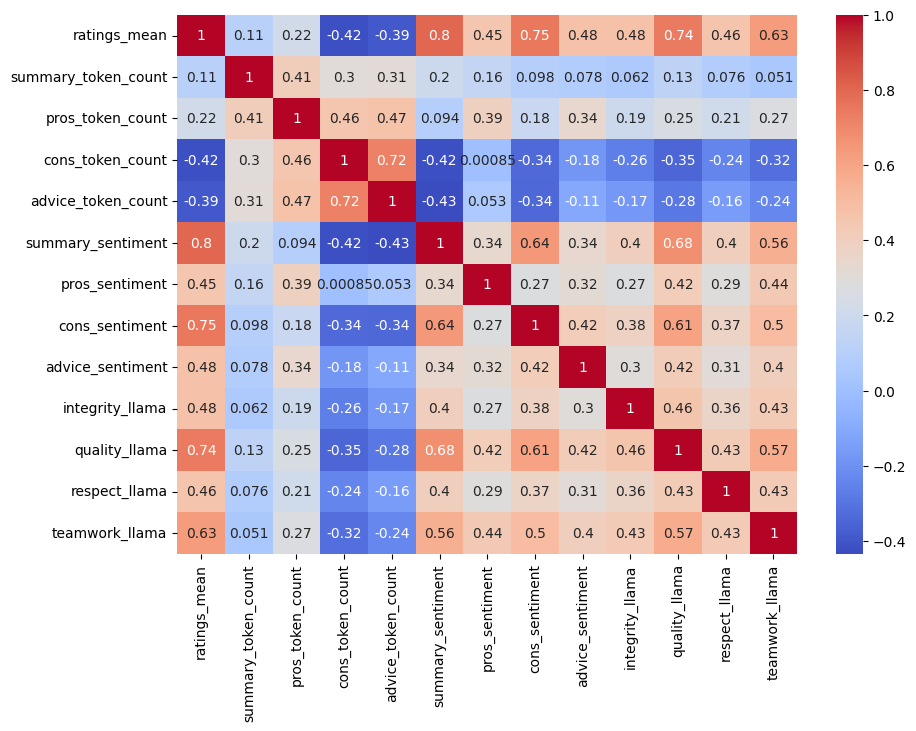

In [20]:
cols_features = ['ratings_mean',
                 'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count',
                 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
                 'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

corr_matrix = df[cols_features].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

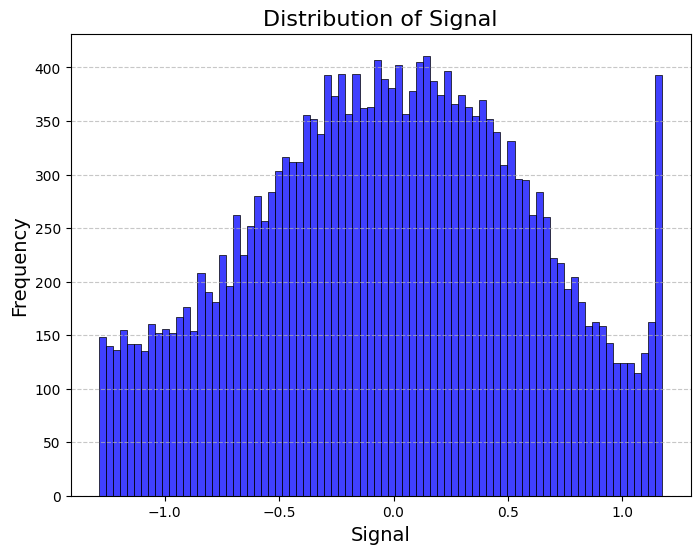

In [21]:
plt.figure(figsize=(8, 6))
sns.histplot(df['ratings_mean'], bins=80, color='blue', edgecolor='black')

plt.title('Distribution of Signal', fontsize=16)
plt.xlabel('Signal', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

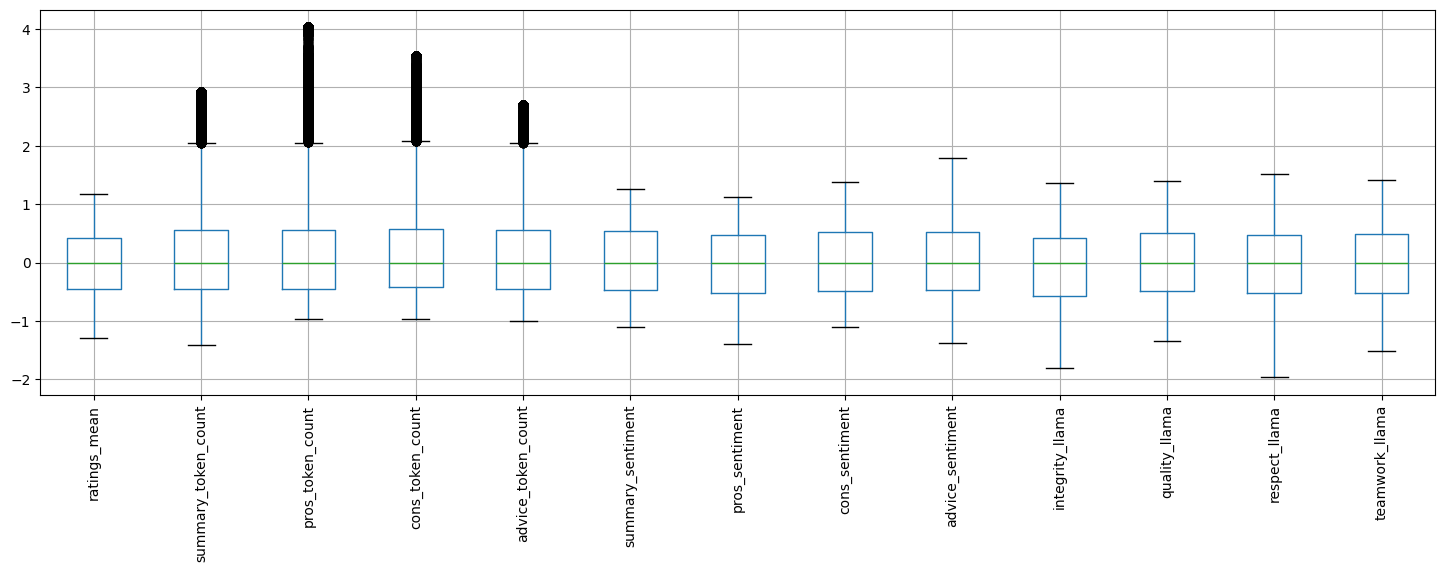

In [22]:
cols_features = ['ratings_mean',
                 'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count',
                 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
                 'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

df[cols_features].boxplot(figsize = (18,5))
plt.xticks(rotation=90)
plt.show()

### backtest

In [23]:
df.columns

Index(['year_month', 'cusip', 'ratingDiversityAndInclusion',
       'summary_token_count', 'pros_token_count', 'cons_token_count',
       'advice_token_count', 'summary_sentiment', 'pros_sentiment',
       'cons_sentiment', 'advice_sentiment', 'mkvalt', 'integrity_llama',
       'quality_llama', 'respect_llama', 'teamwork_llama', 'review_count',
       'vol_forward_1m', 'return_forward_1m', 'gsector', 'ggroup', 'gind',
       'gsubind', 'year', 'month', 'ratings_mean'],
      dtype='object')

In [24]:
df['cons_token_count'] = -df['cons_token_count']
df['advice_token_count'] = -df['advice_token_count']

cols = ['ratings_mean',
        'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count',
        'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
        'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

df['score'] = df[cols].mean(axis=1)
df.drop(columns=cols, axis=1, inplace=True)

In [ ]:
# evaluate large/mid/small market cap firms

df['score'] = np.where(df['mkvalt'] >= 2000, df['score'], np.nan) # mid + large

# df['score'] = np.where(df['mkvalt'] >= 10000, df['score'], np.NaN)
# df['score'] = np.where((df['mkvalt'] >= 2000) & (df['mkvalt'] <= 10000), np.NaN, df['score'])
# df['score'] = np.where(df['mkvalt'] <= 2000, df['score'], np.NaN)

Overall Annual Sharpe Ratio: 1.0171623591961751
--------------
Yearly Sharpe Ratio
year_month
2014    2.128279
2015    0.537145
2016    0.943831
2017    3.382680
2018    1.331913
2019    1.701326
2020    1.902349
2021   -0.195172
2022   -1.551509
dtype: float64
--------------
Yearly Return (%)
year_month
2014     9.055674
2015     3.773681
2016     5.899078
2017    22.633457
2018    23.075498
2019    20.671940
2020    45.940194
2021    -3.569826
2022    -8.966505
dtype: float64


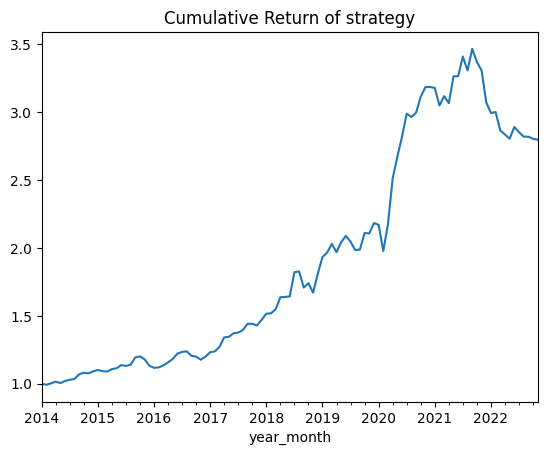

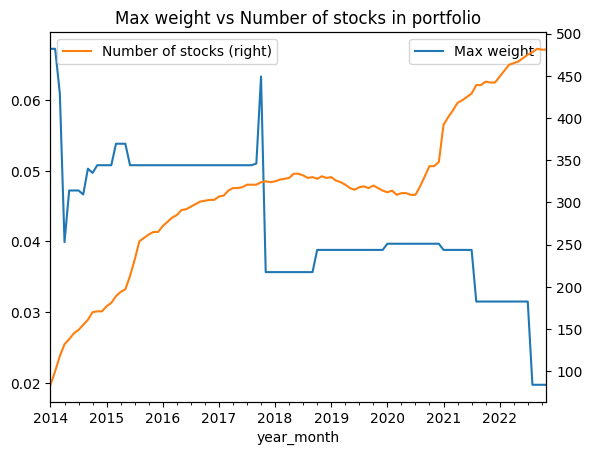

In [26]:
return_xnd = df[['year_month','cusip','return_forward_1m']].pivot(index = 'year_month', columns = 'cusip', values = 'return_forward_1m')

factor = 'score'

factor_xnd = df[['year_month','cusip', factor]].pivot(index = 'year_month', columns = 'cusip', values = factor)
factor_xnd = neutralise_by_group(factor_xnd, "gsubind") # gsector / ggroup / gind / gsubind
factor_xnd = factor_xnd.rolling(36, min_periods = 1).mean()

portfolio_return = run_backtest(return_xnd, factor_xnd)
plot_backtest(portfolio_return)
plot_weights(factor_xnd)